In this script we will perform velocity analyses on the MAPS project.

In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import os
import glob
import loompy
import re
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix

In [2]:
os.chdir('/home/andrewliyim/ltytgat/MI-group/ayliyim/projects/TIPRJ0000015_MAPS/crc_metastasis')

Import combined loom files

In [3]:
velocyto = scv.read('../data_preparation/output/loom/velocyto.loom', cache=True)
velocyto

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 127622 × 36601
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## All

In [9]:
all_cbs = pd.read_csv("output/220129/scvelo/all/maps_crc_cellID_obs.csv")
all_umap = pd.read_csv("output/220129/scvelo/all/maps_crc_cell_embeddings.csv")
all_cellmetadata = pd.read_csv("output/220129/scvelo/all/maps_crc_metadata.csv")

In [10]:
all_scvelo = velocyto[np.isin(velocyto.obs.index, all_cbs["x"])]

In [11]:
all_scvelo_index = pd.DataFrame(all_scvelo.obs.index)
all_scvelo_index = all_scvelo_index.rename(columns = {0:'CellID'})

In [12]:
all_umap = all_umap.rename(columns = {'Unnamed: 0':'CellID'})
all_umap_ordered = all_scvelo_index.merge(all_umap, on = "CellID")
all_umap_ordered = all_umap_ordered.iloc[:,1:]

In [13]:
all_scvelo.obsm['X_umap'] = all_umap_ordered.values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
all_cellmetadata = all_cellmetadata.rename(columns = {'Unnamed: 0':'CellID'})
all_cellmetadata_ordered = all_scvelo_index.merge(all_cellmetadata, on = "CellID")

In [15]:
all_cellmetadata_ordered = all_cellmetadata_ordered.iloc[:,1:]
all_scvelo.obs['tissue'] = all_cellmetadata_ordered.Tissue.values
all_scvelo.obs['celltype'] = all_cellmetadata_ordered.celltype_l3.values

### scVelo

In [16]:
scv.pp.filter_and_normalize(all_scvelo)
scv.pp.moments(all_scvelo)
scv.tl.velocity(all_scvelo, mode = "stochastic")
scv.tl.velocity_graph(all_scvelo)
scv.tl.velocity_pseudotime(all_scvelo)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:27) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:01:07) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:04:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)


  0%|          | 0/40824 [00:00<?, ?cells/s]

    finished (0:32:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 9 regions of root cells and 5 regions of end points .
    finished (0:00:32) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


computing velocity embedding
    finished (0:00:24) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


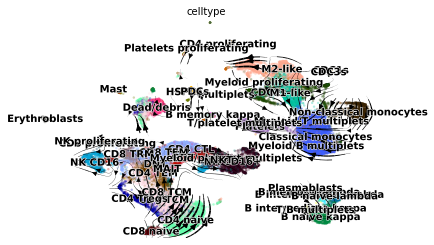

In [18]:
scv.pl.velocity_embedding_stream(all_scvelo, basis = 'umap', color = 'celltype')

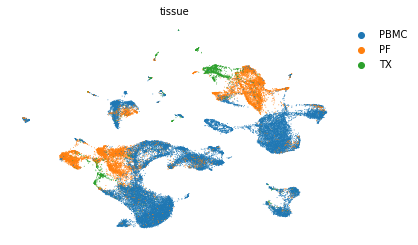

In [21]:
scv.pl.scatter(all_scvelo, color='tissue', cmap='gnuplot')

In [17]:
all_scvelo.write("output/220129/scvelo/all/maps_crc_all_anndata.h5ad")

<AxesSubplot:>

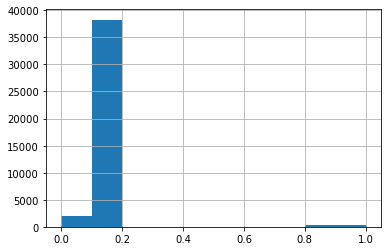

In [24]:
all_scvelo.obs["velocity_pseudotime"].hist()

### CD8

In [61]:
cd8_cbs = pd.read_csv("output/220129/scvelo/cd8/maps_crc_cd8_cellID_obs.csv")
cd8_umap = pd.read_csv("output/220129/scvelo/cd8/maps_crc_cd8_cell_embeddings.csv")
cd8_cellmetadata = pd.read_csv("output/220129/scvelo/cd8/maps_crc_cd8_metadata.csv")

In [62]:
cd8_scvelo = velocyto[np.isin(velocyto.obs.index, cd8_cbs["x"])]

Extract the overlapping cell barcodes

In [63]:
cd8_scvelo_index = pd.DataFrame(cd8_scvelo.obs.index)
cd8_scvelo_index = cd8_scvelo_index.rename(columns = {0:'CellID'})

In [64]:
cd8_umap = cd8_umap.rename(columns = {'Unnamed: 0':'CellID'})
cd8_umap_ordered = cd8_scvelo_index.merge(cd8_umap, on = "CellID")
cd8_umap_ordered = cd8_umap_ordered.iloc[:,1:]

In [65]:
cd8_scvelo.obsm['X_umap'] = cd8_umap_ordered.values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [66]:
cd8_cellmetadata = cd8_cellmetadata.rename(columns = {'Unnamed: 0':'CellID'})
cd8_cellmetadata_ordered = cd8_scvelo_index.merge(cd8_cellmetadata, on = "CellID")

In [67]:
cd8_cellmetadata_ordered = cd8_cellmetadata_ordered.iloc[:,1:]
cd8_scvelo.obs['tissue'] = cd8_cellmetadata_ordered.Tissue.values
cd8_scvelo.obs['celltype'] = cd8_cellmetadata_ordered.celltype_l3.values

#### scVelo

In [68]:
scv.pp.filter_and_normalize(cd8_scvelo)
scv.pp.moments(cd8_scvelo)
scv.tl.velocity(cd8_scvelo, mode = "stochastic")
scv.tl.velocity_graph(cd8_scvelo)
scv.tl.velocity_pseudotime(cd8_scvelo)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)


  0%|          | 0/811 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


saving figure to file output/220129/scvelo/cd8/cd8_scvelo.svg


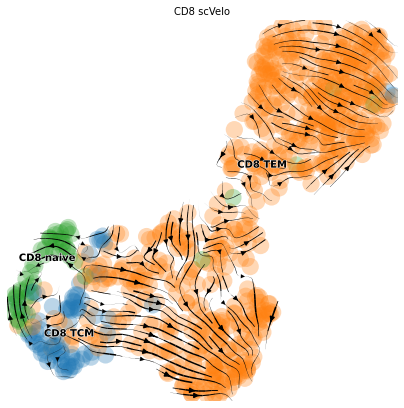

In [120]:
scv.pl.velocity_embedding_stream(cd8_scvelo, basis = 'umap', color = 'celltype', figsize = (7,7), title = "CD8 scVelo", save = "output/220129/scvelo/cd8/cd8_scvelo.svg")

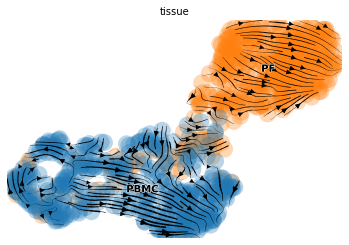

In [70]:
scv.pl.velocity_embedding_stream(cd8_scvelo, basis = 'umap', color = 'tissue')

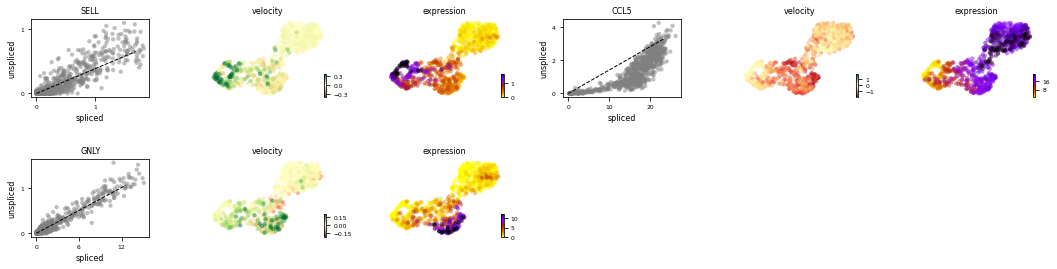

In [72]:
scv.pl.velocity(cd8_scvelo, ['SELL', 'CCL5', 'GNLY'], ncols=2)

In [74]:
cd8_scvelo

AnnData object with n_obs × n_vars = 811 × 36601
    obs: 'Clusters', '_X', '_Y', 'tissue', 'celltype', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'celltype_colors', 'tissue_colors'
    obsm: 'X_umap', 'X_pca', 'velocity_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

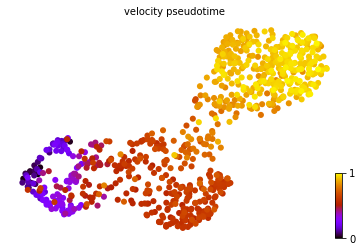

In [73]:
scv.pl.scatter(cd8_scvelo, color='velocity_pseudotime', cmap='gnuplot')

Which genes are associated with the different inferred trajectories

In [ ]:
scv.tl.rank_velocity_genes(cd8_scvelo, groupby='celltype')

In [ ]:
scv.DataFrame(cd8_scvelo.uns['rank_velocity_genes']['names'])

In [ ]:
scv.tl.differential_kinetic_test(cd8_scvelo, groupby='tissue')

In [ ]:
scv.get_df(cd8_scvelo[:, :], ['fit_diff_kinetics', 'fit_pval_kinetics'], precision=2)

In [ ]:
scv.pl.scatter(cd8_scvelo, basis="CSF3R", add_outline='fit_diff_kinetics')

### CD4

In [105]:
cd4_cbs = pd.read_csv("output/220129/scvelo/cd4/maps_crc_cd4_cellID_obs.csv")
cd4_umap = pd.read_csv("output/220129/scvelo/cd4/maps_crc_cd4_cell_embeddings.csv")
cd4_cellmetadata = pd.read_csv("output/220129/scvelo/cd4/maps_crc_cd4_metadata.csv")

In [106]:
cd4_scvelo = velocyto[np.isin(velocyto.obs.index, cd4_cbs["x"])]

Extract the overlapping cell barcodes

In [107]:
cd4_scvelo_index = pd.DataFrame(cd4_scvelo.obs.index)
cd4_scvelo_index = cd4_scvelo_index.rename(columns = {0:'CellID'})

In [108]:
cd4_umap = cd4_umap.rename(columns = {'Unnamed: 0':'CellID'})
cd4_umap_ordered = cd4_scvelo_index.merge(cd4_umap, on = "CellID")
cd4_umap_ordered = cd4_umap_ordered.iloc[:,1:]

In [109]:
cd4_scvelo.obsm['X_umap'] = cd4_umap_ordered.values

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [110]:
cd4_cellmetadata = cd4_cellmetadata.rename(columns = {'Unnamed: 0':'CellID'})
cd4_cellmetadata_ordered = cd4_scvelo_index.merge(cd4_cellmetadata, on = "CellID")

In [111]:
cd4_cellmetadata_ordered = cd4_cellmetadata_ordered.iloc[:,1:]
cd4_scvelo.obs['tissue'] = cd4_cellmetadata_ordered.Tissue.values
cd4_scvelo.obs['celltype'] = cd4_cellmetadata_ordered.celltype_l3.values

### scVelo

In [112]:
scv.pp.filter_and_normalize(cd4_scvelo)
scv.pp.moments(cd4_scvelo)
scv.tl.velocity(cd4_scvelo, mode = "stochastic")
scv.tl.velocity_graph(cd4_scvelo)
scv.tl.velocity_pseudotime(cd4_scvelo)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:12) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)


  0%|          | 0/2771 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


saving figure to file output/220129/scvelo/cd4/cd4_scvelo.pdf


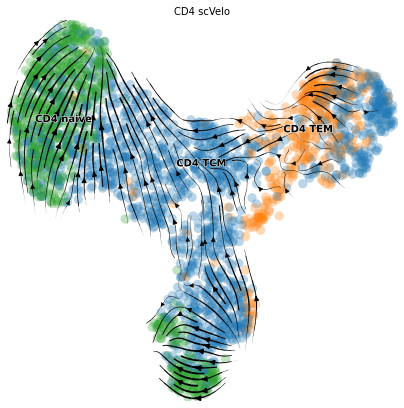

In [119]:
scv.pl.velocity_embedding_stream(cd4_scvelo, basis = 'umap', color = 'celltype', figsize = (7,7), title = "CD4 scVelo", save = "output/220129/scvelo/cd4/cd4_scvelo.pdf")

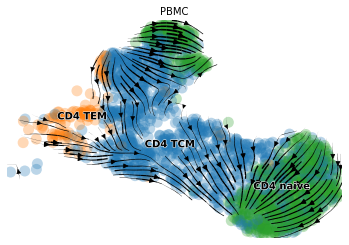

In [101]:
scv.pl.velocity_embedding_stream(cd4_scvelo[cd4_scvelo.obs['tissue'].isin(['PBMC'])], basis = 'umap', color = 'celltype', title= "PBMC")

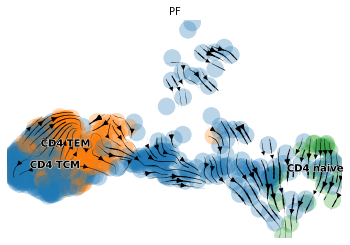

In [102]:
scv.pl.velocity_embedding_stream(cd4_scvelo[cd4_scvelo.obs['tissue'].isin(['PF'])], basis = 'umap', color = 'celltype', title= "PF")

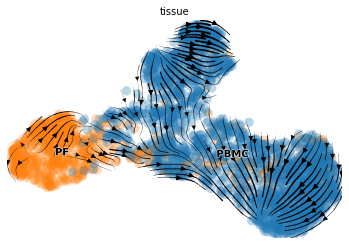

In [103]:
scv.pl.velocity_embedding_stream(cd4_scvelo, basis = 'umap', color = 'tissue')

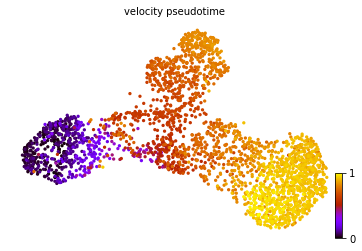

In [104]:
scv.pl.scatter(cd4_scvelo, color='velocity_pseudotime', cmap='gnuplot')